In [2]:
!python --version
!pip list
# Pip
!pip install --disable-pip-version-check -q pip --upgrade > /dev/null
!pip install --disable-pip-version-check -q wrapt --upgrade > /dev/null
# AWS CLI and AWS Python SDK (boto3)
!pip install --disable-pip-version-check -q awscli==1.18.216 boto3==1.16.56 botocore==1.19.56
# SageMaker
!pip install --disable-pip-version-check -q sagemaker==2.29.0
!pip install --disable-pip-version-check -q smdebug==1.0.1
!pip install --disable-pip-version-check -q sagemaker-experiments==0.1.26
# PyTorch
!conda install -y pytorch==1.6.0 -c pytorch
# TensorFlow
!pip install --disable-pip-version-check -q tensorflow==2.3.1
# Hugging Face Transformers (BERT)
!pip install --disable-pip-version-check -q transformers==3.5.1
# TorchServe
!pip install --disable-pip-version-check -q torchserve==0.3.0
!pip install --disable-pip-version-check -q torch-model-archiver==0.3.0
# PyAthena
!pip install --disable-pip-version-check -q PyAthena==2.1.0
# Redshift
!pip install --disable-pip-version-check -q SQLAlchemy==1.3.22
# AWS Data Wrangler
!pip install --disable-pip-version-check -q awswrangler==2.3.0
# StepFunctions
!pip install --disable-pip-version-check -q stepfunctions==2.0.0rc1
# Zip
!conda install -y zip
# Matplotlib
!pip install --disable-pip-version-check -q matplotlib==3.1.3
# Seaborn
!pip install --disable-pip-version-check -q seaborn==0.10.0


# Summarize
!python --version
# !pip list
setup_dependencies_passed = True
%store setup_dependencies_passed
%store

Python 3.7.10
Package                              Version
------------------------------------ -----------------
aiobotocore                          2.4.2
aiohttp                              3.8.4
aioitertools                         0.11.0
aiosignal                            1.3.1
alabaster                            0.7.12
anaconda-client                      1.7.2
anaconda-project                     0.8.3
ansi2html                            1.8.0
anyio                                3.6.2
argh                                 0.26.2
argon2-cffi                          21.3.0
argon2-cffi-bindings                 21.2.0
asn1crypto                           1.3.0
astroid                              2.15.1
astropy                              4.3.1
async-timeout                        4.0.2
asynctest                            0.13.0
atomicwrites                         1.3.0
attrs                                22.2.0
autopep8                             1.4.4
autovizwidget     

In [3]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
import io
import sagemaker
from sagemaker import get_execution_role
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
from pyathena import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform
import warnings
warnings.filterwarnings('ignore')

In [4]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [5]:
import json

notebook_instance_name = None

try:
    with open("/opt/ml/metadata/resource-metadata.json") as notebook_info:
        data = json.load(notebook_info)
        domain_id = data["DomainId"]
        resource_arn = data["ResourceArn"]
        region = resource_arn.split(":")[3]
        name = data["ResourceName"]
    print("DomainId: {}".format(domain_id))
    print("Name: {}".format(name))
except:
    print("+++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR]: COULD NOT RETRIEVE THE METADATA.")
    print("+++++++++++++++++++++++++++++++++++++++++")

DomainId: d-x9g2xqzh9zoe
Name: datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395


In [6]:
describe_domain_response = sm.describe_domain(DomainId=domain_id)
print(describe_domain_response["Status"])

InService


In [7]:
try:
    get_status_response = sm.get_sagemaker_servicecatalog_portfolio_status()
    print(get_status_response["Status"])
except:
    pass

Enabled


In [8]:
if (
    describe_domain_response["Status"] == "InService"
    and get_status_response["Status"] == "Enabled"
    and "datascience" in name
):
    setup_instance_check_passed = True
    print("[OK] Checks passed!  Great Job!!  Please Continue.")
else:
    setup_instance_check_passed = False
    print("+++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR]: WE HAVE IDENTIFIED A MISCONFIGURATION.")
    print(describe_domain_response["Status"])
    print(get_status_response["Status"])
    print(name)
    print("+++++++++++++++++++++++++++++++++++++++++++++++")

[OK] Checks passed!  Great Job!!  Please Continue.


In [9]:
import boto3
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [10]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


In [11]:
admin = False
post_policies = iam.list_attached_role_policies(RoleName=role_name)["AttachedPolicies"]
for post_policy in post_policies:
    if post_policy["PolicyName"] == "AdministratorAccess":
        admin = True
        break

setup_iam_roles_passed = True
print("[OK] You are all set up to continue with this workshop!")

[OK] You are all set up to continue with this workshop!


In [12]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [13]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [14]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [15]:
database_name = "CA_Traffic"

In [16]:
bucket = sess.default_bucket()
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [17]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)


In [18]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS CA_Traffic


In [19]:
import pandas as pd



In [20]:
pd.read_sql(statement, conn)

""


In [21]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,ca_traffic
1,default
2,goldendrive


In [22]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [23]:
# Set Athena parameters
database_name = "ca_traffic"
Ex_Ln_table = "Ex_Ln"
HOV_table = "HOV"
vol_table = "vol"
Route77_table = 'Route77'
s3_path_Ex_Ln = "s3://{}/Express_Lanes.csv".format(bucket)
s3_path_HOV = "s3://{}/HOV.csv".format(bucket)
s3_path_vol = "s3://{}/Traffic_Volumes_AADT.csv".format(bucket)
s3_path_Route77 = "s3://{}/Route_77.csv".format(bucket)

In [24]:
statement1 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         District int,
         Route string,
         Direction string,
         Begin_County string,
         Begin_Post_Mile string,
         End_County string,
         End_Post_Mile string,
         Begin_Abs_Post_Mile int,
         End_Abs_Post_Mile int,
         Description string,
         Length__Lane_Miles_ int,
         Opening_Date string,
         Occupancy_Requirement_for_Toll_ string,
         Hours_of_Operation string,
         Comments string,
         Shape_Length int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, Ex_Ln_table, s3_path_Ex_Ln
)

pd.read_sql(statement1, conn)


""


In [25]:
statement2 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         District int,
         Route string,
         Direction string,
         Begin_County string,
         Begin_Post_Mile string,
         End_County string,
         End_Post_Mile string,
         Begin_Abs_Post_Mile int,
         End_Abs_Post_Mile int,
         Description string,
         Length__Lane_Miles_ int,
         Occupancy_Requirement string,
         Hours_of_Operation string,
         Segment_Opening_Date string,
         Comments string,
         Shape_Length int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, HOV_table, s3_path_HOV
)

pd.read_sql(statement2, conn)

""


In [26]:
statement3 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         District int,
         Route int,       
         RTE_SFX string,      
         COUNTY string,
         PM_PFX string, 
         PM int,
         PM_SFX string,
         DESCRIPTION string,
         BACK_PEAK_HOUR int,
         BACK_PEAK_MADT int,
         BACK_AADT int,
         AHEAD_PEAK_HOUR int,
         AHEAD_PEAK_MADT int,
         AHEAD_AADT int   
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, vol_table, s3_path_vol
)

pd.read_sql(statement3, conn)


""


In [27]:

statement4 = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Date DATE,
         Day string,
         Lane string,
         Date_Time TIMESTAMP,
         Time TIMESTAMP,      
         Minimum int,
         Mean int, 
         Maximum int,
         Lane_Pts_num int,
         Oberserved_percent int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, Route77_table, s3_path_Route77
)

pd.read_sql(statement4, conn)

""


In [106]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,ex_ln
1,hov
2,route77
3,vol


In [33]:
#HOV


HOV_df = pd.read_csv("s3://sagemaker-us-east-1-938981654669/GoldenDrive/Data/HOV.csv")
HOV_df.info()
HOV_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OBJECTID               109 non-null    int64  
 1   District               109 non-null    int64  
 2   Route                  109 non-null    object 
 3   Direction              109 non-null    object 
 4   Begin_County           109 non-null    object 
 5   Begin_Post_Mile        109 non-null    object 
 6   End_County             109 non-null    object 
 7   End_Post_Mile          109 non-null    object 
 8   Begin_Abs_Post_Mile    106 non-null    float64
 9   End_Abs_Post_Mile      106 non-null    float64
 10  Description            109 non-null    object 
 11  Length__Lane_Miles_    109 non-null    float64
 12  Occupancy_Requirement  109 non-null    object 
 13  Hours_of_Operation     109 non-null    object 
 14  Segment_Opening_Date   105 non-null    object 
 15  Commen

,OBJECTID,District,Route,Direction,Begin_County,Begin_Post_Mile,End_County,End_Post_Mile,Begin_Abs_Post_Mile,End_Abs_Post_Mile,Description,Length__Lane_Miles_,Occupancy_Requirement,Hours_of_Operation,Segment_Opening_Date,Comments,Shape_Length
0,1,3,50,EB,SAC,R5.371,ED,5.834,11.005,34.632,Watt Ave to Cameron Park Dr,23.627,2+,M-F 06:00-10:00 and 15:00-19:00,Watt Ave to Sunrise Blvd - Dec 2011; Sunrise B...,NaN,48659.155980
1,2,3,80,EB,SAC,M0.767,PLA,4.718,84.691,106.237,West El Camino Ave to SR-65,21.546,2+,M-F 06:00-10:00 and 15:00-19:00,Yolo Co Line to Longview Dr - Dec 2016; Longvi...,NaN,44432.185806
2,3,4,80,EB,SOL,0.504,SOL,0.673,27.995,28.164,Carquinez Bridge Toll Plaza,0.255,3+,M-F 05:00-10:00 and 15:00-19:00,"Opened; W/O Toll Plaza to E/O Toll Plaza, 07/3...",2-Seat Vehicles with 2 Persons Permitted; Toll...,348.131415
3,4,4,80,EB,SOL,R11.485,SOL,19.594,38.976,47.096,Red Top Road to Air Base Pkwy,8.120,2+,M-F 05:00-10:00 and 15:00-19:00,"Opened; Red Top Road to E/O Air Base Pkwy., 11...",NaN,16660.846138
4,5,7,10,EB,LA,30.995,LA,48.265,29.495,46.765,I-605 to San Bernardino County Line,17.270,2+,24 Hr,Rte 605 to 0.6 mi west of Puente Ave (Francisq...,Continues into San Bernardino County,33527.727027


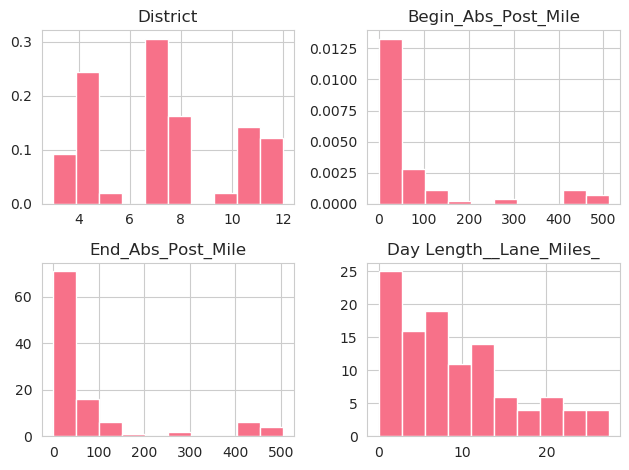

In [34]:
n_bins = 10
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

ax0.hist(HOV_df['District'], n_bins, density=True, histtype='bar', stacked = True)
ax0.set_title('District')

ax1.hist(HOV_df['Begin_Abs_Post_Mile'], n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('Begin_Abs_Post_Mile')

ax2.hist(HOV_df['End_Abs_Post_Mile'], n_bins, histtype='bar', stacked=True)
ax2.set_title('End_Abs_Post_Mile')

ax3.hist(HOV_df['Length__Lane_Miles_'], n_bins, histtype='bar', stacked=True)
ax3.set_title('Day Length__Lane_Miles_')

fig.tight_layout()
plt.show()


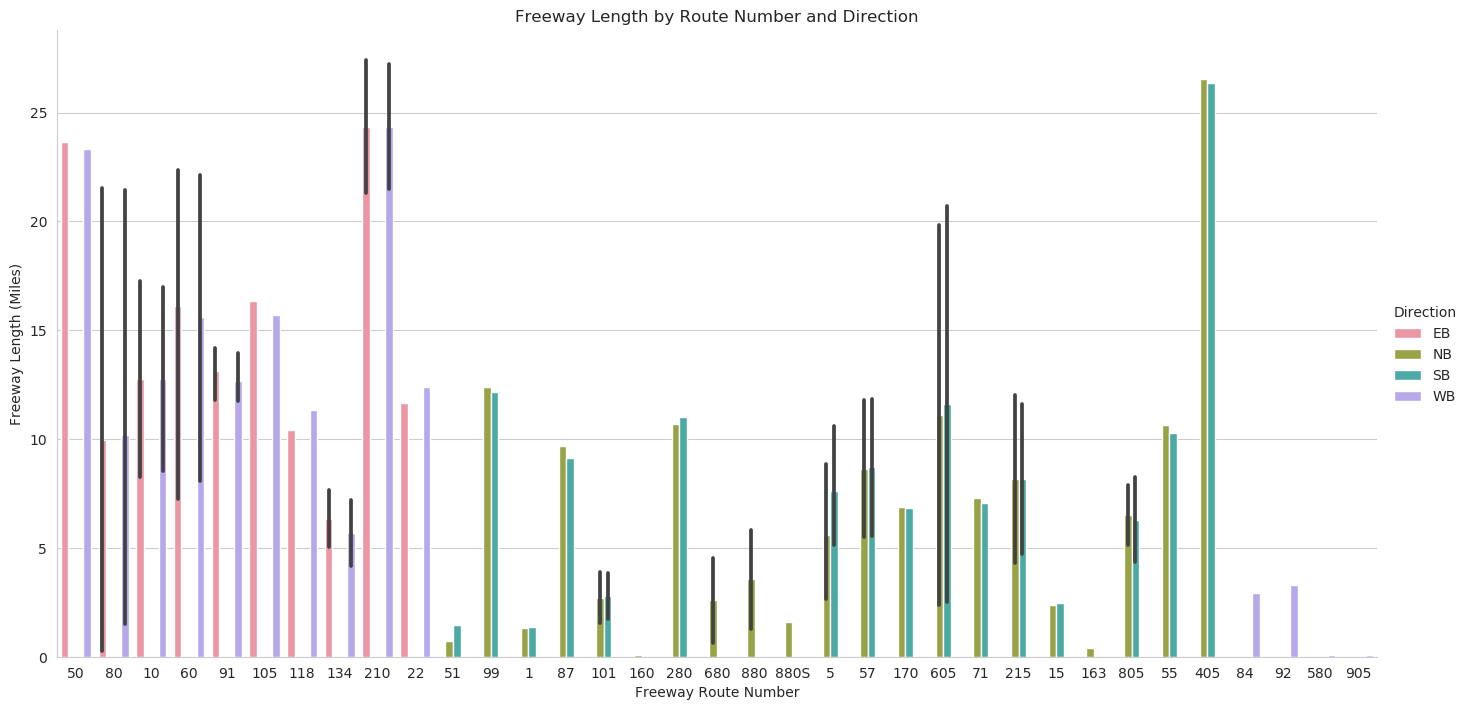

In [35]:
# Create a grouped bar chart using seaborn
sns.set_style("whitegrid")
sns.set_palette("husl", 2)
ax = sns.catplot(x='Route', y='Length__Lane_Miles_', hue='Direction', 
                 kind='bar', data=HOV_df, height = 7, aspect=2)

# Set the axis labels and title
ax.set_xlabels('Freeway Route Number')
ax.set_ylabels('Freeway Length (Miles)')
ax.set(title='Freeway Length by Route Number and Direction')

# Show the plot
plt.show()

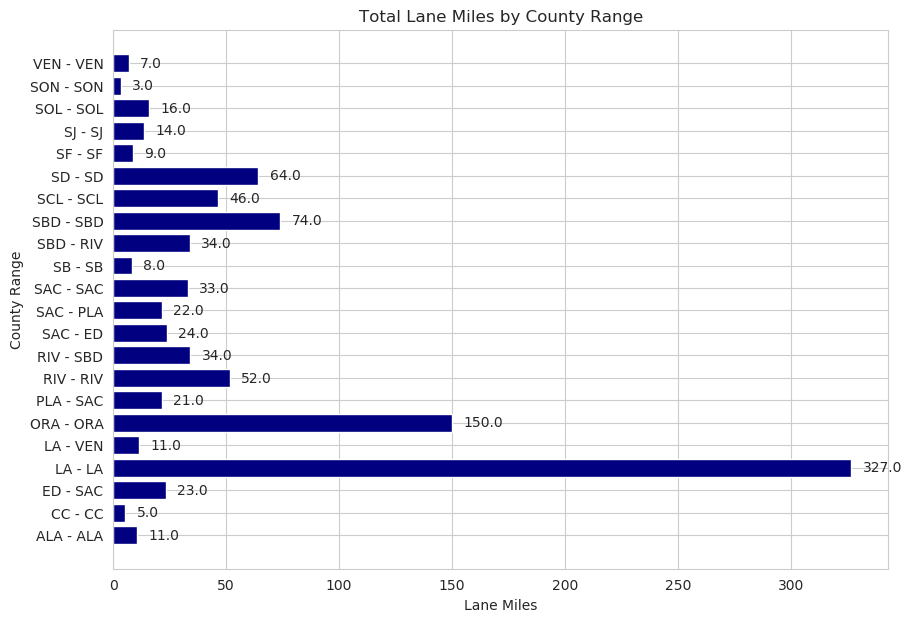

In [36]:
# Group the data by county and sum the lane miles
grouped_data = HOV_df.groupby(['Begin_County', 'End_County']).agg({'Length__Lane_Miles_': 'sum'}).reset_index()

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(y=grouped_data['Begin_County'] + ' - ' + grouped_data['End_County'], width=grouped_data['Length__Lane_Miles_'], color='navy')

# Set the axis labels and title
ax.set_xlabel('Lane Miles')
ax.set_ylabel('County Range')
ax.set_title('Total Lane Miles by County Range')

# Add labels to the bars
for i, bar in enumerate(bars):
    value = bar.get_width()
    x_pos = value + 5
    y_pos = i
    ax.text(x_pos, y_pos, str(round(value)), va='center')

# Show the plot
plt.show()

In [37]:
#Traffic volume table

# vol_df = pd.read_csv("s3://sagemaker-us-east-1-938981654669/GoldenDrive/Data/Traffic_Volumes_AADT.csv")
vol_df = pd.read_csv("s3://sagemaker-us-east-1-938981654669/GoldenDrive/Data/HOV2.csv")
#"s3://sagemaker-us-east-1-938981654669/GoldenDrive/Data/HOV.csv"
#vol_df.info()
#vol_df.head(5)

In [38]:
grouped_data = vol_df.groupby('ROUTE').mean().reset_index()
grouped_data_back = grouped_data[['ROUTE', 'BACK_PEAK_HOUR','BACK_AADT']]
grouped_data_back['Rate'] = (grouped_data_back['BACK_PEAK_HOUR'] / grouped_data_back['BACK_AADT']) * 100
grouped_data_back = grouped_data_back.sort_values( "Rate", ascending = False).head(10)
grouped_data_back.style.background_gradient(cmap="Blues")
grouped_data_back

,ROUTE,BACK_PEAK_HOUR,BACK_AADT,Rate
187,220,474.000000,322.000000,147.204969
178,207,300.000000,740.000000,40.540541
120,136,80.000000,280.000000,28.571429
225,284,100.000000,370.000000,27.027027
217,270,120.000000,450.000000,26.666667
214,266,40.000000,160.000000,25.000000
206,254,263.333333,1106.666667,23.795181
146,167,20.000000,90.000000,22.222222
131,150,1967.333333,9116.666667,21.579525
138,158,255.000000,1187.500000,21.473684


In [39]:
grouped_data_ahead = grouped_data[['ROUTE', 'AHEAD_PEAK_HOUR','AHEAD_AADT']]
grouped_data_ahead['Rate'] = (grouped_data_ahead['AHEAD_PEAK_HOUR'] / grouped_data_ahead['AHEAD_AADT']) * 100
grouped_data_ahead = grouped_data_ahead.sort_values( "Rate", ascending = False).head(10)
grouped_data_ahead.style.background_gradient(cmap="Blues")
grouped_data_ahead

,ROUTE,AHEAD_PEAK_HOUR,AHEAD_AADT,Rate
217,270,90.000000,210.000000,42.857143
178,207,300.000000,750.000000,40.000000
192,229,60.000000,170.000000,35.294118
214,266,75.000000,215.000000,34.883721
84,95,718.000000,2685.000000,26.741155
187,220,76.000000,322.000000,23.602484
85,96,272.727273,1155.681818,23.598820
138,158,315.000000,1342.500000,23.463687
225,284,150.000000,660.000000,22.727273
218,271,51.428571,226.428571,22.712934


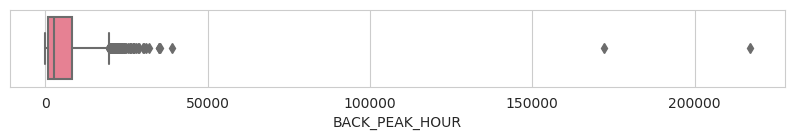

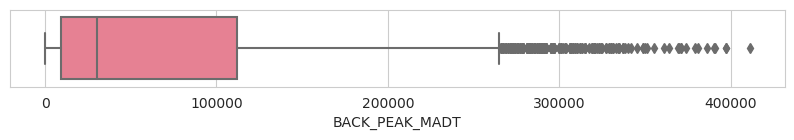

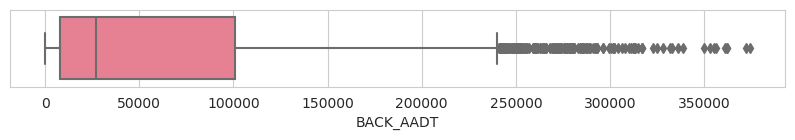

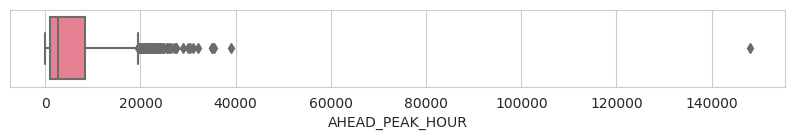

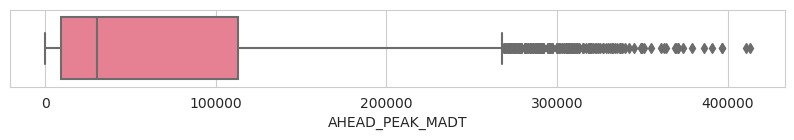

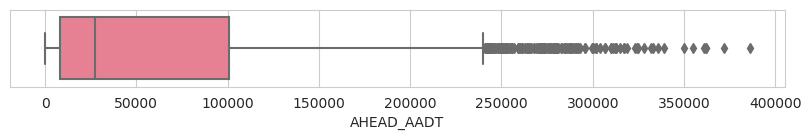

In [40]:
fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.BACK_PEAK_HOUR)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.BACK_PEAK_MADT)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.BACK_AADT)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.AHEAD_PEAK_HOUR)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.AHEAD_PEAK_MADT)

fig,ax = plt.subplots(figsize = (10,1))
sns.boxplot(vol_df.AHEAD_AADT)

In [41]:
#route77


route77_df = pd.read_csv("s3://sagemaker-us-east-1-938981654669/GoldenDrive/Data/Route_77.csv")
route77_df = pd.DataFrame(route77_df)
route77_df.info()
route77_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                10080 non-null  object 
 1   Day                 10080 non-null  object 
 2   Lane                10080 non-null  object 
 3   Date_Time           10080 non-null  object 
 4   Time                10080 non-null  object 
 5   Minimum             10080 non-null  float64
 6   Mean                10080 non-null  float64
 7   Maximum             10080 non-null  float64
 8   Lane_Pts_num        10080 non-null  int64  
 9   Oberserved_percent  10080 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 787.6+ KB


,Date,Day,Lane,Date_Time,Time,Minimum,Mean,Maximum,Lane_Pts_num,Oberserved_percent
0,3/5/23,Sunday,Lane1,3/5/23 0:00,0:00:00,30.37,30.37,30.37,318,38.7
1,3/5/23,Sunday,Lane1,3/5/23 0:05,0:05:00,30.40,30.40,30.40,318,39.3
2,3/5/23,Sunday,Lane1,3/5/23 0:10,0:10:00,30.45,30.45,30.45,317,39.1
3,3/5/23,Sunday,Lane1,3/5/23 0:15,0:15:00,30.52,30.52,30.52,317,38.8
4,3/5/23,Sunday,Lane1,3/5/23 0:20,0:20:00,30.40,30.40,30.40,318,39.3


In [42]:
route77_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                10080 non-null  object 
 1   Day                 10080 non-null  object 
 2   Lane                10080 non-null  object 
 3   Date_Time           10080 non-null  object 
 4   Time                10080 non-null  object 
 5   Minimum             10080 non-null  float64
 6   Mean                10080 non-null  float64
 7   Maximum             10080 non-null  float64
 8   Lane_Pts_num        10080 non-null  int64  
 9   Oberserved_percent  10080 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 787.6+ KB


In [43]:
# Add the needed columns for better visualization, and transform the data type.
route77_df['Date_Time'] = pd.to_datetime(route77_df['Date_Time'])
route77_df['dt'] = pd.to_datetime(route77_df['Date_Time'])
route77_df['dt'] = route77_df['dt'].dt.date
route77_df['time_s']  = route77_df['Date_Time'].dt.time
route77_df

,Date,Day,Lane,Date_Time,Time,Minimum,Mean,Maximum,Lane_Pts_num,Oberserved_percent,dt,time_s
0,3/5/23,Sunday,Lane1,2023-03-05 00:00:00,0:00:00,30.37,30.37,30.37,318,38.7,2023-03-05,00:00:00
1,3/5/23,Sunday,Lane1,2023-03-05 00:05:00,0:05:00,30.40,30.40,30.40,318,39.3,2023-03-05,00:05:00
2,3/5/23,Sunday,Lane1,2023-03-05 00:10:00,0:10:00,30.45,30.45,30.45,317,39.1,2023-03-05,00:10:00
3,3/5/23,Sunday,Lane1,2023-03-05 00:15:00,0:15:00,30.52,30.52,30.52,317,38.8,2023-03-05,00:15:00
4,3/5/23,Sunday,Lane1,2023-03-05 00:20:00,0:20:00,30.40,30.40,30.40,318,39.3,2023-03-05,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...
10075,3/11/23,Saturday,HOV,2023-03-11 23:35:00,23:35:00,31.30,31.30,31.30,316,5.1,2023-03-11,23:35:00
10076,3/11/23,Saturday,HOV,2023-03-11 23:40:00,23:40:00,31.25,31.25,31.25,317,5.0,2023-03-11,23:40:00
10077,3/11/23,Saturday,HOV,2023-03-11 23:45:00,23:45:00,31.23,31.23,31.23,316,5.1,2023-03-11,23:45:00
10078,3/11/23,Saturday,HOV,2023-03-11 23:50:00,23:50:00,31.27,31.27,31.27,317,5.0,2023-03-11,23:50:00


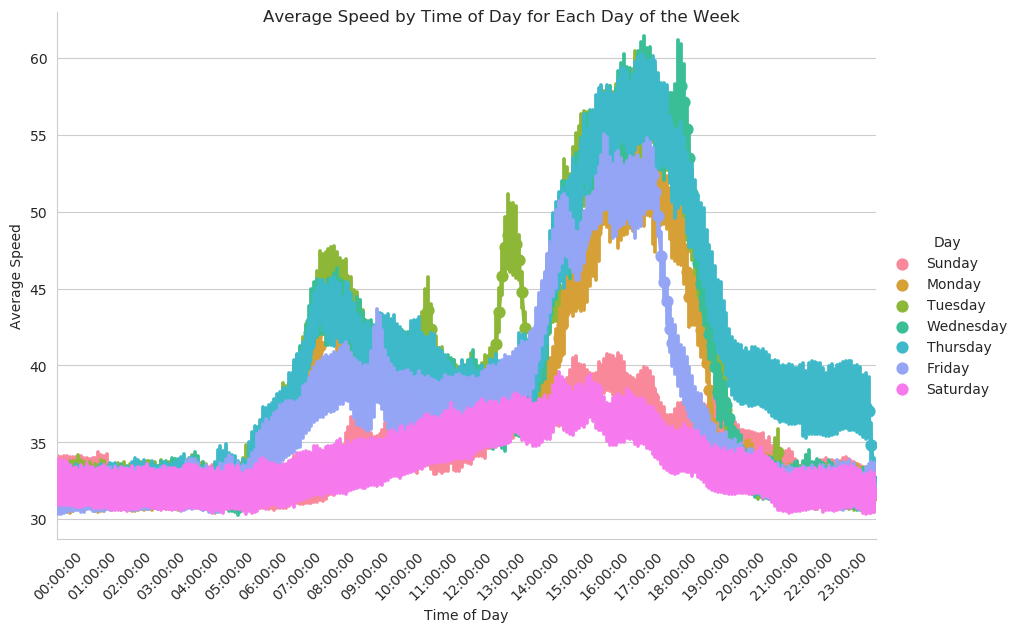

In [44]:
import matplotlib.ticker as ticker 

sns.set_style("whitegrid")
g = sns.catplot(x="time_s", y="Mean", hue="Day", data=route77_df, kind="point", height=6, aspect=1.5)

g.set_xlabels("Time of Day")
g.set_ylabels("Average Speed")
plt.xticks(rotation=45)
g.fig.suptitle("Average Speed by Time of Day for Each Day of the Week")

ax = g.facet_axis(0,0)   
every_nth = 12
for i, label in enumerate(ax.get_xticklabels()):
    if i % every_nth != 0:
        label.set_visible(False)    
    
plt.show()

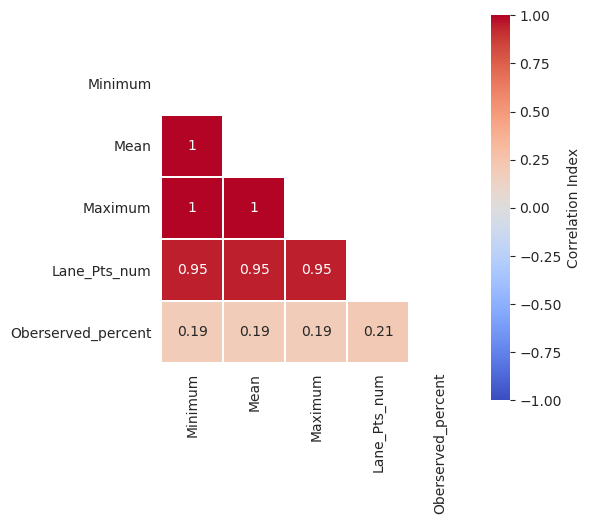

In [45]:
# assign correlation function to new variable
corr = route77_df.corr()
matrix = np.triu(corr) # for triangular matrix
plt.figure(figsize=(5,5))
# parse corr variable intro triangular matrix
sns.heatmap(route77_df.corr(method='pearson'), 
            annot=True, linewidths=.5, 
            cmap="coolwarm", mask=matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'}, 
            vmin=-1, vmax=1)
plt.show()

In [46]:
# create a new table to store the needed data
route = pd.DataFrame([route77_df.dt, route77_df.Day,route77_df.Lane,route77_df.Mean,route77_df.time_s]).transpose()
route.head(5)

,dt,Day,Lane,Mean,time_s
0,2023-03-05,Sunday,Lane1,30.37,00:00:00
1,2023-03-05,Sunday,Lane1,30.40,00:05:00
2,2023-03-05,Sunday,Lane1,30.45,00:10:00
3,2023-03-05,Sunday,Lane1,30.52,00:15:00
4,2023-03-05,Sunday,Lane1,30.40,00:20:00


In [47]:
route77_df.columns

Index(['Date', 'Day', 'Lane', 'Date_Time', 'Time', 'Minimum', 'Mean',
       'Maximum', 'Lane_Pts_num', 'Oberserved_percent', 'dt', 'time_s'],
      dtype='object')

In [48]:
route['dt'] = pd.to_datetime(route['dt'])
# route['time_s'] = pd.to_datetime(route['time_s'])
route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      10080 non-null  datetime64[ns]
 1   Day     10080 non-null  object        
 2   Lane    10080 non-null  object        
 3   Mean    10080 non-null  object        
 4   time_s  10080 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 393.9+ KB


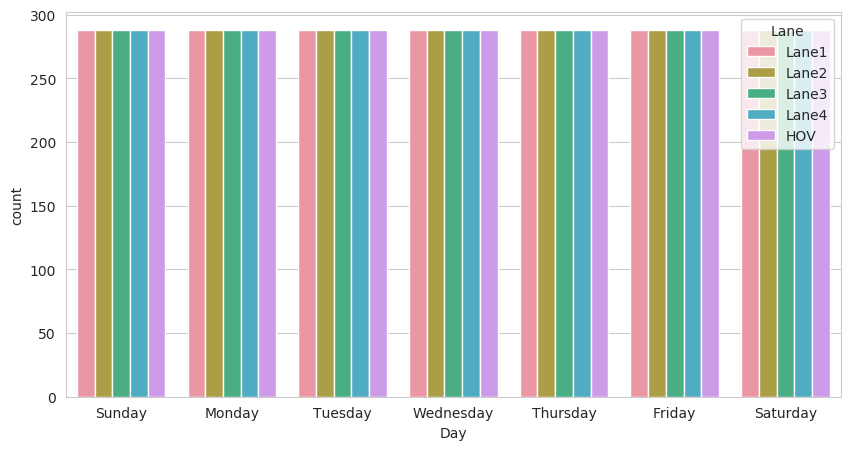

In [49]:
plt.figure(figsize=(10,5))
sns.countplot(data=route, x="Day", hue="Lane")
plt.show()


In [50]:
#split hov


hov_df = route[route['Lane'] == 'HOV']
hov_df

,dt,Day,Lane,Mean,time_s
1152,2023-03-05,Sunday,HOV,31.95,00:00:00
1153,2023-03-05,Sunday,HOV,31.97,00:05:00
1154,2023-03-05,Sunday,HOV,32.00,00:10:00
1155,2023-03-05,Sunday,HOV,32.03,00:15:00
1156,2023-03-05,Sunday,HOV,31.93,00:20:00
...,...,...,...,...,...
10075,2023-03-11,Saturday,HOV,31.30,23:35:00
10076,2023-03-11,Saturday,HOV,31.25,23:40:00
10077,2023-03-11,Saturday,HOV,31.23,23:45:00
10078,2023-03-11,Saturday,HOV,31.27,23:50:00


In [51]:
lan_df = route[route['Lane'] != 'HOV']
lan_df

,dt,Day,Lane,Mean,time_s
0,2023-03-05,Sunday,Lane1,30.37,00:00:00
1,2023-03-05,Sunday,Lane1,30.40,00:05:00
2,2023-03-05,Sunday,Lane1,30.45,00:10:00
3,2023-03-05,Sunday,Lane1,30.52,00:15:00
4,2023-03-05,Sunday,Lane1,30.40,00:20:00
...,...,...,...,...,...
9787,2023-03-11,Saturday,Lane4,34.02,23:35:00
9788,2023-03-11,Saturday,Lane4,34.05,23:40:00
9789,2023-03-11,Saturday,Lane4,34.05,23:45:00
9790,2023-03-11,Saturday,Lane4,34.10,23:50:00


In [52]:
merged_df = pd.merge(hov_df, lan_df, on=[ 'Day','time_s'])
merged_df

,dt_x,Day,Lane_x,Mean_x,time_s,dt_y,Lane_y,Mean_y
0,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane1,30.37
1,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane2,31.43
2,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane3,34.08
3,2023-03-05,Sunday,HOV,31.95,00:00:00,2023-03-05,Lane4,34.85
4,2023-03-05,Sunday,HOV,31.97,00:05:00,2023-03-05,Lane1,30.40
...,...,...,...,...,...,...,...,...
8059,2023-03-11,Saturday,HOV,31.27,23:50:00,2023-03-11,Lane4,34.10
8060,2023-03-11,Saturday,HOV,31.32,23:55:00,2023-03-11,Lane1,29.60
8061,2023-03-11,Saturday,HOV,31.32,23:55:00,2023-03-11,Lane2,30.95
8062,2023-03-11,Saturday,HOV,31.32,23:55:00,2023-03-11,Lane3,32.57


In [53]:
dummies = pd.get_dummies(merged_df[['Lane_y', 'Day', 'time_s']])
new_dum = pd.concat([merged_df, dummies], axis=1)

# drop the original 'Lane' and 'Day_of_Week' columns
new_dum.drop(['Lane_y', 'Day','time_s'], axis=1, inplace=True)

# print the resulting dataframe
print(new_dum)

           dt_x Lane_x Mean_x       dt_y Mean_y  Lane_y_Lane1  Lane_y_Lane2  \
0    2023-03-05    HOV  31.95 2023-03-05  30.37             1             0   
1    2023-03-05    HOV  31.95 2023-03-05  31.43             0             1   
2    2023-03-05    HOV  31.95 2023-03-05  34.08             0             0   
3    2023-03-05    HOV  31.95 2023-03-05  34.85             0             0   
4    2023-03-05    HOV  31.97 2023-03-05  30.40             1             0   
...         ...    ...    ...        ...    ...           ...           ...   
8059 2023-03-11    HOV  31.27 2023-03-11  34.10             0             0   
8060 2023-03-11    HOV  31.32 2023-03-11  29.60             1             0   
8061 2023-03-11    HOV  31.32 2023-03-11  30.95             0             1   
8062 2023-03-11    HOV  31.32 2023-03-11  32.57             0             0   
8063 2023-03-11    HOV  31.32 2023-03-11  34.28             0             0   

      Lane_y_Lane3  Lane_y_Lane4  Day_Friday  ...  

In [85]:
#modeling



In [54]:
# Get the variable list and remove the target variable and irrelevant columns
column_names = list(new_dum.columns)
column_names.remove('dt_x')
column_names.remove('Lane_x')
column_names.remove('Mean_x')
column_names.remove('dt_y')
# Print the list of column names
print(column_names)

['Mean_y', 'Lane_y_Lane1', 'Lane_y_Lane2', 'Lane_y_Lane3', 'Lane_y_Lane4', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'time_s_00:00:00', 'time_s_00:05:00', 'time_s_00:10:00', 'time_s_00:15:00', 'time_s_00:20:00', 'time_s_00:25:00', 'time_s_00:30:00', 'time_s_00:35:00', 'time_s_00:40:00', 'time_s_00:45:00', 'time_s_00:50:00', 'time_s_00:55:00', 'time_s_01:00:00', 'time_s_01:05:00', 'time_s_01:10:00', 'time_s_01:15:00', 'time_s_01:20:00', 'time_s_01:25:00', 'time_s_01:30:00', 'time_s_01:35:00', 'time_s_01:40:00', 'time_s_01:45:00', 'time_s_01:50:00', 'time_s_01:55:00', 'time_s_02:00:00', 'time_s_02:05:00', 'time_s_02:10:00', 'time_s_02:15:00', 'time_s_02:20:00', 'time_s_02:25:00', 'time_s_02:30:00', 'time_s_02:35:00', 'time_s_02:40:00', 'time_s_02:45:00', 'time_s_02:50:00', 'time_s_02:55:00', 'time_s_03:00:00', 'time_s_03:05:00', 'time_s_03:10:00', 'time_s_03:15:00', 'time_s_03:20:00', 'time_s_03:25:00', 'time_s_03:30:00', 't

In [55]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

X = new_dum[column_names]
Y = new_dum['Mean_x']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


In [56]:
print("x_train:",x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape[0])
print("y_test:",y_test.shape[0])

x_train: (6451, 300)
x_test: (1613, 300)
y_train: 6451
y_test: 1613


In [57]:
#LinearRegression model
from sklearn.linear_model import LinearRegression
# Train a linear regression model on the training set
regressor = LinearRegression()
# Fit the regressor with the training data
regressor.fit(x_train, y_train)
# Predict the values for the test set
y_pred = regressor.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.8525872352074951


In [58]:
from sklearn.metrics import r2_score
Accuracy_lr=r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy_lr)

 Accuracy of the model is 97.51


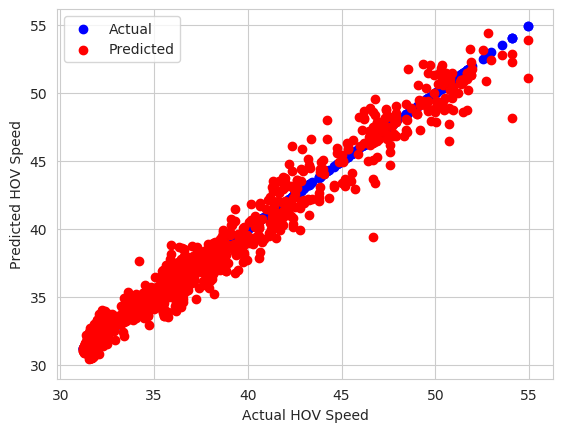

In [59]:
# Plot the actual values
plt.scatter(y_test, y_test, color='blue', label='Actual')

# Plot the predicted values
plt.scatter(y_test, y_pred, color='red', label='Predicted')

# Set the axis labels and legend
plt.xlabel('Actual HOV Speed')
plt.ylabel('Predicted HOV Speed')
plt.legend()

# Show the plot
plt.show()


In [64]:
from sklearn.metrics import mean_squared_error
import math

print('RMSE for linear regression model is: ', math.sqrt(mean_squared_error(y_test, y_pred)))

RMSE for this model is:  0.8525872352074951


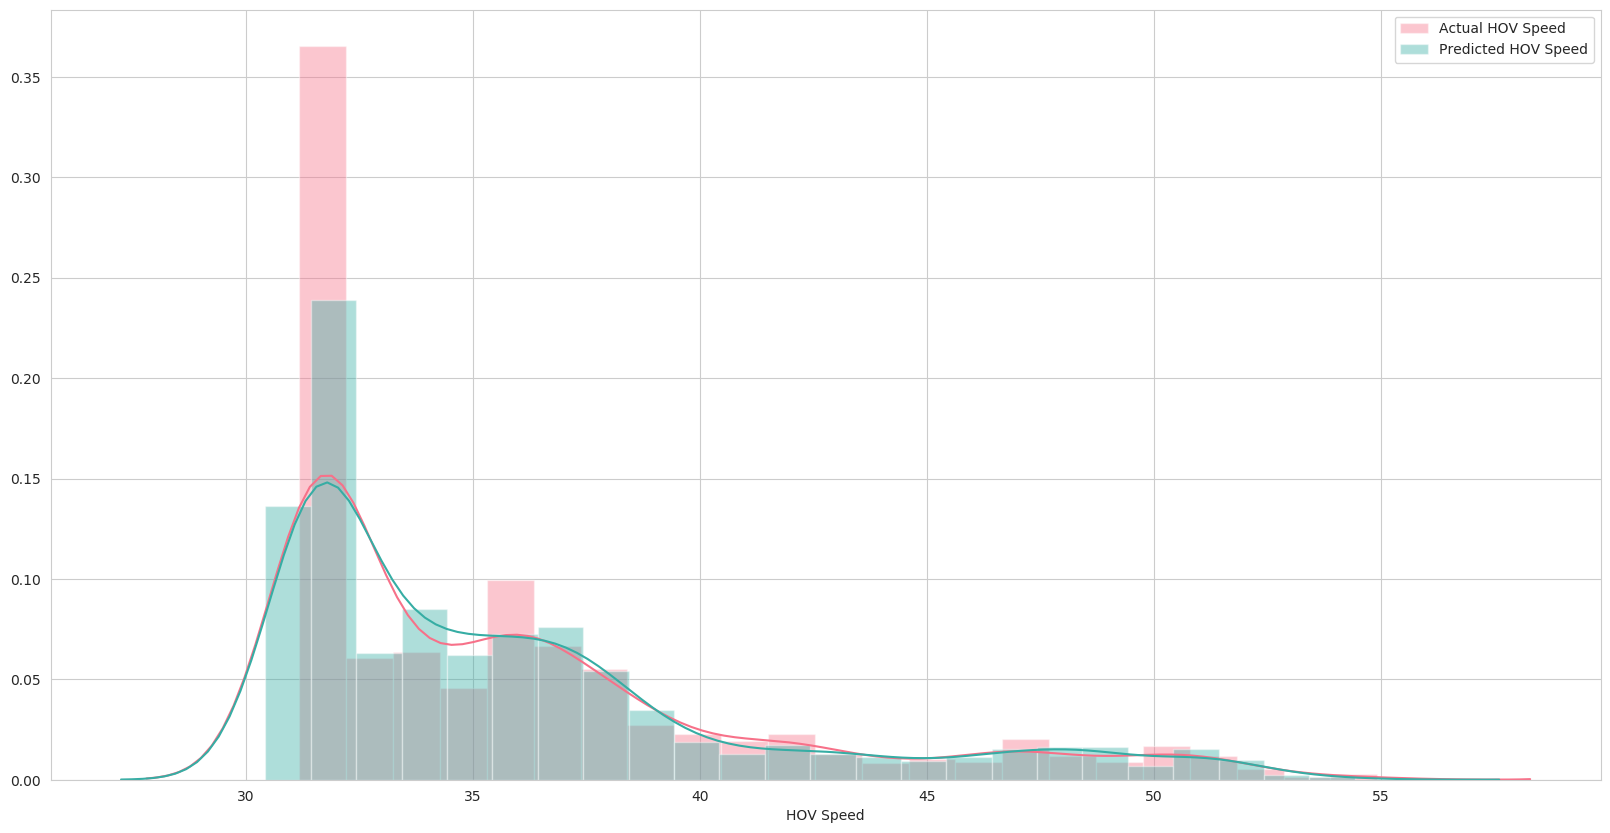

In [60]:
f, ax = plt.subplots(figsize=(20, 10)) 
sns.distplot(y_test, hist=True, label="Actual HOV Speed")
sns.distplot(y_pred, hist=True, label="Predicted HOV Speed")
plt.xlabel("HOV Speed")
plt.legend()
plt.show()

In [93]:
#svm model


In [62]:
import pandas as pd
from sklearn import svm
RegModel = svm.SVR(C=2, kernel='linear')


In [65]:

##Creating the model on Training Data

SVM=RegModel.fit(x_train,y_train)
y_pred_SVM = SVM.predict(x_test)

In [66]:
print('RMSE for SVM model is: ', math.sqrt(mean_squared_error(y_test, y_pred_SVM)))

RMSE for SVM model is:  0.8688802309925242


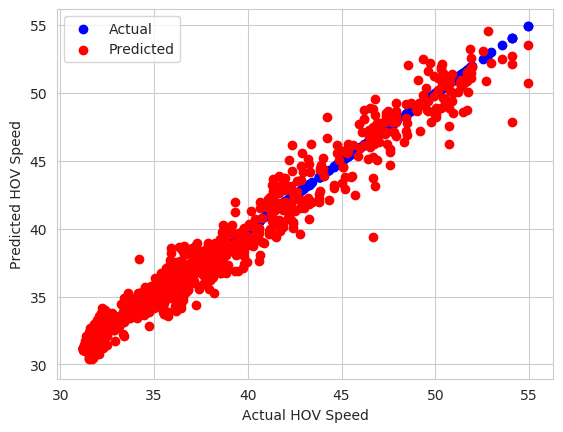

In [67]:
# Plot the actual values
plt.scatter(y_test, y_test, color='blue', label='Actual')

# Plot the predicted values
plt.scatter(y_test, y_pred_SVM, color='red', label='Predicted')

# Set the axis labels and legend
plt.xlabel('Actual HOV Speed')
plt.ylabel('Predicted HOV Speed')
plt.legend()

# Show the plot
plt.show()

In [68]:
x_train.shape

(6451, 300)

In [69]:
y_train.shape

(6451,)

In [72]:
from tensorflow import keras

In [78]:
# Neural Nerwork model
import numpy as np
#from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


# Define the model architecture
model = Sequential()
model.add(Dense(300, input_dim = 300))
model.add(Dense(50, input_dim = 300, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = 'accuracy')

# Train the model
#model.fit(x_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test set
#mse = model.evaluate(x_test, y_test)
#print("MSE:", mse)



In [86]:
x_train = pd.DataFrame(x_train)
x_train = np.array(x_train)
x_train = np.asarray(x_train).astype('float32')

In [87]:
type(y_train)

pandas.core.series.Series

In [89]:
# Train the model
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
202/202 [==============================] - 1s 4ms/step - loss: 435.3265 - accuracy: 0.0000e+00
Epoch 2/50
202/202 [==============================] - 0s 2ms/step - loss: 2.9116 - accuracy: 0.0000e+00
Epoch 3/50
202/202 [==============================] - 0s 2ms/step - loss: 2.4536 - accuracy: 0.0000e+00
Epoch 4/50
202/202 [==============================] - 0s 2ms/step - loss: 2.2456 - accuracy: 0.0000e+00
Epoch 5/50
202/202 [==============================] - 0s 2ms/step - loss: 2.2866 - accuracy: 0.0000e+00
Epoch 6/50
202/202 [==============================] - 0s 2ms/step - loss: 2.2302 - accuracy: 0.0000e+00
Epoch 7/50
202/202 [==============================] - 0s 2ms/step - loss: 2.3563 - accuracy: 0.0000e+00
Epoch 8/50
202/202 [==============================] - 0s 2ms/step - loss: 2.1729 - accuracy: 0.0000e+00
Epoch 9/50
202/202 [==============================] - 0s 2ms/step - loss: 2.0458 - accuracy: 0.0000e+00
Epoch 10/50
202/202 [==============================] - 0s 2ms/

In [94]:
# Evaluate the model on the test set
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
a,b = model.evaluate(x_test, y_test)

print("RMSE for the NN model",math.sqrt(a))

51/51 [==============================] - 0s 1ms/step - loss: 1.0833 - accuracy: 0.0000e+00
RMSE for the NN model 1.0408129754275839


In [96]:
y_pred_NN = model.predict(x_test)
print('RMSE for NN model is: ', math.sqrt(mean_squared_error(y_test, y_pred_NN)))

RMSE for NN model is:  1.0408129754275839


RMSE value for k=  1 is: 0.26082146447296145
RMSE value for k=  2 is: 0.4543010170967615
RMSE value for k=  3 is: 0.7759674747062697
RMSE value for k=  4 is: 1.1082518415488163
RMSE value for k=  5 is: 1.480368084788379
RMSE value for k=  6 is: 1.812941790440021
RMSE value for k=  7 is: 2.032807337033337
RMSE value for k=  8 is: 2.120563391043881
RMSE value for k=  9 is: 2.104251908927339
RMSE value for k=  10 is: 2.0507945988496266
RMSE value for k=  11 is: 2.0500865054173754
RMSE value for k=  12 is: 2.0813188139835512
RMSE value for k=  13 is: 2.139939360089919
RMSE value for k=  14 is: 2.217768493535663
RMSE value for k=  15 is: 2.3155614381806235
RMSE value for k=  16 is: 2.423410613448646
RMSE value for k=  17 is: 2.5420543653237133
RMSE value for k=  18 is: 2.653140481749042
RMSE value for k=  19 is: 2.773606036963338
RMSE value for k=  20 is: 2.849876939648576


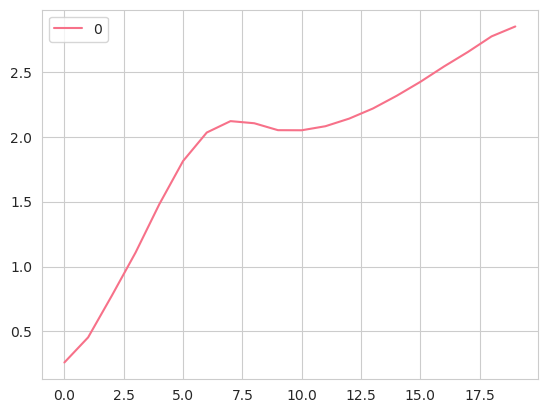

In [117]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [122]:


#predicting on the test set
predict = model.predict(x_test)



In [98]:
# evaluate an xgboost regression model 
import sys

!{sys.executable} -m pip install xgboost

from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
#load the dataset
#model = XGBRegressor()
# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)


In [100]:
#load the dataset
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model.fit(x_train,y_train)
y_pred_XGB = model.predict(x_test)
# evaluate model
# scores = cross_val_score(model, x_train, y_train, scoring='mean_squared_error', cv=cv, n_jobs=-1)



In [103]:
print('RMSE for XGB model is: ', math.sqrt(mean_squared_error(y_test, y_pred_XGB)))

RMSE for XGB model is:  0.6188560818758817


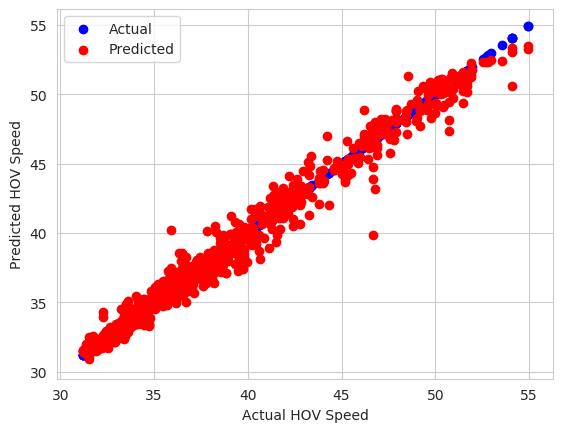

In [104]:
# Plot the actual values
plt.scatter(y_test, y_test, color='blue', label='Actual')

# Plot the predicted values
plt.scatter(y_test, y_pred_XGB, color='red', label='Predicted')

# Set the axis labels and legend
plt.xlabel('Actual HOV Speed')
plt.ylabel('Predicted HOV Speed')
plt.legend()

# Show the plot
plt.show()